In [2]:
import cudf
import matplotlib.pyplot as plt
import os
import torch

In [ ]:
# Загрузка датасета
chat_df = cudf.read_csv('chat_data/chat_history 2024-11-08 v3.csv', dtype={
    'id': 'int32',
    'from_id': 'str',
    'text': 'str',
    'reply_to_id': 'int32'
})
chat_df.date = cudf.to_datetime(chat_df.date)
chat_df.edited = cudf.to_datetime(chat_df.edited.fillna('1970-01-01 00:00:00'))
chat_df = chat_df[~chat_df.text.str.startswith('File: <')]


def load_embeddings(folder, m=0, n=-1):
    files = os.listdir(folder)
    if not isinstance(m, int) or m < 0 or m >= n:
        m = 0
        
    if not isinstance(n, int) or n < 1 or n > len(files):
        n = len(files)
    
    files = files[m:n]
    all_embeds = [torch.load(folder + '/' + files[0])]
    for i, t in enumerate(files[1:]):
        all_embeds.append(torch.load(folder + '/' + t))
        if (i + 1) % 200 == 0:
            print((i + 1) * 50)
            
    return all_embeds

embeds = torch.concat(load_embeddings('chat_analysis/embeds'))
embeds.shape

/tmp/ipykernel_19860/684110296.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_embeds = [torch.load(folder + '/' + files[0])]
/tmp/ipykernel_19860/684110296.py:24: 

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000


torch.Size([138631, 1024])

24
36
42
47
50
148
168
274


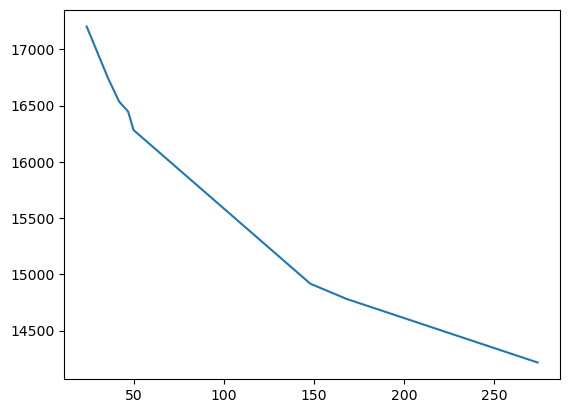

In [ ]:
# По методу локтя определяем оптимальное число кластеров
from cuml.cluster import KMeans
from cuml import TSNE


# k = 24, 36, 42, 47, 50, 148, 168, 274?
metrics = []
# proj = TSNE(n_components=2, perplexity=50, early_exaggeration=24, metric='euclidean', n_iter=2000, verbose=True).fit_transform(embeds)
for k in [24, 36, 42, 47, 50, 148, 168, 274]:
    kmeans = KMeans(n_clusters=k, max_iter=100, verbose=1,
                    init='scalable-k-means++', oversampling_factor=4)
    kmeans.fit(embeds)
    metrics.append(-kmeans.score(embeds))
    print(k)

plt.plot([24, 36, 42, 47, 50, 148, 168, 274], metrics)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=42, max_iter=100, verbose=1,
                init='scalable-k-means++', oversampling_factor=4)
kmeans_labels = kmeans.fit_predict(embeds)
chat_df['kmeans'] = kmeans_labels
chat_df[['kmeans']].to_csv('chat_analysis/clusters/kmeans_labels1.csv', index=True)

In [ ]:
from cuml.cluster import DBSCAN
from cuml import TSNE


dbscan = DBSCAN(eps=0.35, min_samples=4, metric='euclidean', algorithm='brute', verbose=True)
dbscan_labels = dbscan.fit_predict(TSNE(n_components=2, perplexity=50, early_exaggeration=24, 
                                        metric='euclidean', n_iter=2000, verbose=True).fit_transform(embeds))
print('algorithm has converged')

chat_df['dbscan'] = dbscan_labels
chat_df[['dbscan']].to_csv('chat_analysis/clusters/dbscan_labels2.csv', index=True)

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


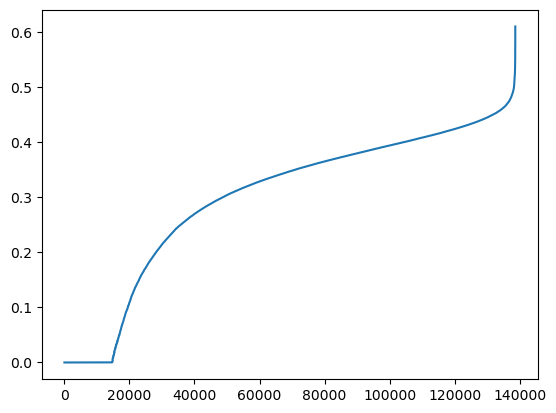

In [ ]:
# Попытка по точкам перегиба определить оптимальные параметры для DBSCAN
from cuml.neighbors import NearestNeighbors


nbrs = NearestNeighbors(n_neighbors=17)
nbrs.fit(embeds)
dists, indices = nbrs.kneighbors(embeds)
dists = dists[:, 1:].mean(axis=1)
dists.sort()
plt.plot(range(len(dists)), dists.get())
plt.show()

In [ ]:
from cuml.cluster import HDBSCAN


hdbscan = HDBSCAN(min_samples=1, metric='l2', min_cluster_size=100, cluster_selection_epsilon=0.3, verbose=True)
hdbscan_labels = hdbscan.fit_predict(embeds)
print('algorithm has converged')

chat_df['hdbscan'] = hdbscan_labels
chat_df[['hdbscan']].to_csv('chat_analysis/clusters/hdbscan_labels3.csv', index=True)

algorithm has converged


In [ ]:
from cuml.cluster import AgglomerativeClustering


aggl = AgglomerativeClustering(n_clusters=100, metric='cosine', connectivity='knn', n_neighbors=2)
aggl_labels = aggl.fit_predict(embeds)
print('algorithm has converged')

chat_df['aggl'] = aggl_labels
chat_df[['aggl']].to_csv('chat_analysis/clusters/aggl_labels1.csv', index=True)

algorithm has converged
